In [1]:
import pandas as pd
import numpy as np
import os
import random
from copy import deepcopy
import math
from itertools import product
import pickle
import joblib
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

# 전후 값 기반 null 대체

초기 null 상태

## 준비

In [2]:
merged_df = pd.read_csv('./customData/merged_user_loan.csv', index_col=0)

In [3]:
merged_df.columns

Index(['application_id', 'user_id', 'birth_year', 'gender', 'insert_time',
       'credit_score', 'yearly_income', 'income_type', 'company_enter_month',
       'employment_type', 'houseown_type', 'desired_amount', 'purpose',
       'personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn',
       'existing_loan_cnt', 'existing_loan_amt', 'loanapply_insert_time',
       'bank_id', 'product_id', 'loan_limit', 'loan_rate', 'is_applied'],
      dtype='object')

In [ ]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

In [4]:
merged_df=merged_df.sort_values(by=['user_id', 'loanapply_insert_time'])

In [5]:
user_id_list = list(merged_df['user_id'])

In [ ]:
idx_uid_list=[]
for uid in tqdm(set(user_id_list)):
    idx_uid_list.append((user_id_list.index(uid),uid))

  8%|██████▎                                                                    | 26929/317467 [01:27<31:19, 154.60it/s]

In [ ]:
idx_uid_list.sort()

In [ ]:
# idx_uid_list

In [ ]:
merged_df.reset_index(inplace=True)

실습

In [28]:
a=pd.DataFrame([
    list(range(1,10)),
    list(range(8,17)),
    [0]*9,
    list(range(31, 13, -2))
])

In [37]:
a.iloc[:,0]=np.NaN

In [35]:
a.iloc[0,0] = 1
a.iloc[0,3] = 2

In [46]:
a.fillna(method='bfill')

,0,1,2,3,4,5,6,7,8
0,NaN,9.0,10.0,2.0,12.0,13.0,14.0,15.0,16.0
1,NaN,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0
2,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,NaN,29.0,27.0,25.0,23.0,21.0,19.0,17.0,15.0


In [42]:
a.fillna(method='ffill').isnull().sum()

0    4
1    1
2    1
3    0
4    1
5    1
6    1
7    1
8    1
dtype: int64

## 앞뒤값으로 null 채우기

In [ ]:
len(idx_uid_list) # 61148

In [63]:
result = pd.DataFrame()
for i, v in tqdm(enumerate(idx_uid_list[:-1])):
    idx=v[0]
    result= pd.concat([result, merged_df.iloc[idx:idx_uid_list[i+1][0]].fillna(method='ffill').fillna(method='bfill')])

61147it [1:04:22, 15.83it/s]


In [65]:
(result.isnull().sum())[result.isnull().sum()!=0]

index                                       0
application_id                              0
user_id                                     0
birth_year                              20771
gender                                  20771
insert_time                                 0
credit_score                           249504
yearly_income                               0
income_type                                 0
company_enter_month                     58008
employment_type                             0
houseown_type                               0
desired_amount                              0
purpose                                     0
personal_rehabilitation_yn             562202
personal_rehabilitation_complete_yn    562202
existing_loan_cnt                      514053
existing_loan_amt                      744018
loanapply_insert_time                       0
bank_id                                     0
product_id                                  0
loan_limit                        

In [ ]:
result.to_csv('./customData/merged_user_loan.csv')

In [71]:
result['is_applied']=merged_df['is_applied']

In [75]:
(result.isnull().sum())[result.isnull().sum()!=0]

birth_year                              20771
gender                                  20771
credit_score                           249504
company_enter_month                     58008
personal_rehabilitation_yn             562202
personal_rehabilitation_complete_yn    562202
existing_loan_cnt                      514053
existing_loan_amt                      744018
loan_limit                                  4
loan_rate                                   4
is_applied                             619682
dtype: int64

In [76]:
(result[result['is_applied'].isnull()==True].isnull().sum())[result[result['is_applied'].isnull()==True].isnull().sum()!=0]

birth_year                               5700
gender                                   5700
credit_score                            50139
company_enter_month                     14269
personal_rehabilitation_yn               3003
personal_rehabilitation_complete_yn      3003
existing_loan_cnt                      105637
existing_loan_amt                      162452
is_applied                             619682
dtype: int64

In [ ]:
result['index'] = result.index

In [73]:
result.to_csv('./customData/merged_ver1_0.csv')

# 의미를 부여하여 결측치 처리하기

## loan_limit & loan_rate

In [38]:
merged_df=pd.read_csv('./customData/merged_ver1_0.csv',index_col=0)

In [75]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                              20771
gender                                  20771
credit_score                           249504
company_enter_month                     58008
personal_rehabilitation_yn             562202
personal_rehabilitation_complete_yn    562202
existing_loan_cnt                      514053
existing_loan_amt                      744018
loan_limit                                  4
loan_rate                                   4
is_applied                             619682
dtype: int64

In [40]:
merged_df.drop(merged_df[merged_df['loan_limit'].isnull()==True].index, inplace=True)

In [41]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                              20771
gender                                  20771
credit_score                           249504
company_enter_month                     58008
personal_rehabilitation_yn             562201
personal_rehabilitation_complete_yn    562201
existing_loan_cnt                      514053
existing_loan_amt                      744017
is_applied                             619682
dtype: int64

## existing_loan_cnt & existing_loan_amt

In [59]:
# merged_df[(merged_df['existing_loan_amt'].isnull()==True) & merged_df['existing_loan_cnt']==1]

In [60]:
merged_df.loc[merged_df[(merged_df['existing_loan_amt'].isnull()==True) & merged_df['existing_loan_cnt']==1].index, 'existing_loan_amt'] = -100

In [61]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                              20771
gender                                  20771
credit_score                           249504
company_enter_month                     58008
personal_rehabilitation_yn             562201
personal_rehabilitation_complete_yn    562201
existing_loan_cnt                      514053
existing_loan_amt                      514053
is_applied                             619682
dtype: int64

In [63]:
set(merged_df[merged_df['existing_loan_amt'].isnull()==True].index) ==\
set(merged_df[merged_df['existing_loan_cnt'].isnull()==True].index)

True

In [67]:
merged_df.loc[merged_df[merged_df['existing_loan_amt'].isnull()==True].index, ['existing_loan_amt', 'existing_loan_cnt']]=0

In [69]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year                              20771
gender                                  20771
credit_score                           249504
company_enter_month                     58008
personal_rehabilitation_yn             562201
personal_rehabilitation_complete_yn    562201
is_applied                             619682
dtype: int64

## personal_rehabilitation_yn & personal_rehabilitation_complete_yn

In [14]:
set(merged_df[merged_df['personal_rehabilitation_yn'].isnull()==True].index)\
== set(merged_df[merged_df['personal_rehabilitation_complete_yn'].isnull()==True].index)

True

In [70]:
merged_df.loc[merged_df[merged_df['personal_rehabilitation_yn'].isnull()==True].index, ['personal_rehabilitation_yn', 'personal_rehabilitation_complete_yn']]=0

In [71]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year              20771
gender                  20771
credit_score           249504
company_enter_month     58008
is_applied             619682
dtype: int64

## company_enter_month     

In [82]:
merged_df['company_enter_month']

0          202201.0
1          202201.0
2          202201.0
3          202201.0
4          202201.0
             ...   
2586454    201803.0
2586455    201803.0
2586456    201803.0
2586457    201803.0
2586458    201803.0
Name: company_enter_month, Length: 2586455, dtype: float64

In [85]:
merged_df['income_type'].unique()

array(['EARNEDINCOME', 'OTHERINCOME', 'EARNEDINCOME2', 'FREELANCER',
       'PRIVATEBUSINESS', 'PRACTITIONER'], dtype=object)

In [89]:
for income_type in merged_df['income_type'].unique():
    print(income_type, merged_df[merged_df['income_type']==income_type]['company_enter_month'].isnull().sum())

EARNEDINCOME 0
OTHERINCOME 58008
EARNEDINCOME2 0
FREELANCER 0
PRIVATEBUSINESS 0
PRACTITIONER 0


In [100]:
merged_df.loc[merged_df[merged_df['company_enter_month'].isnull()==True].index, 'company_enter_month']=0

In [101]:
(merged_df.isnull().sum())[merged_df.isnull().sum()!=0]

birth_year       20771
gender           20771
credit_score    249504
is_applied      619682
dtype: int64

In [102]:
tmp = pd.read_csv('./customData/merged_user_loan.csv')

In [103]:
tmp['is_applied'].isnull().sum()

3257239

In [104]:
merged_df.shape

(2586455, 24)

In [99]:
merged_df[merged_df['is_applied'].isnull()==True]['insert_time'].str[:7].unique()

array(['2022-06', '2022-05'], dtype=object)

In [84]:
merged_df[['income_type','company_enter_month']]

,income_type,company_enter_month
0,EARNEDINCOME,202201.0
1,EARNEDINCOME,202201.0
2,EARNEDINCOME,202201.0
3,EARNEDINCOME,202201.0
4,EARNEDINCOME,202201.0
...,...,...
2586454,PRACTITIONER,201803.0
2586455,PRACTITIONER,201803.0
2586456,PRACTITIONER,201803.0
2586457,PRACTITIONER,201803.0


In [79]:
df = merged_df[merged_df['company_enter_month'].isnull()==True]

In [80]:
df.describe()

,index,application_id,user_id,birth_year,gender,credit_score,yearly_income,company_enter_month,desired_amount,personal_rehabilitation_yn,personal_rehabilitation_complete_yn,existing_loan_cnt,existing_loan_amt,bank_id,product_id,loan_limit,loan_rate,is_applied
count,5.800800e+04,5.800800e+04,58008.000000,56798.000000,56798.000000,49190.000000,5.800800e+04,0.0,5.800800e+04,58008.000000,58008.000000,58008.000000,5.800800e+04,58008.000000,58008.000000,5.800800e+04,58008.000000,43739.000000
mean,1.271071e+06,1.089368e+06,83087.060233,1978.565812,0.465192,753.692417,3.021876e+07,NaN,3.656842e+07,0.006206,0.000793,2.618104,3.150799e+07,27.789701,133.035685,1.574021e+07,14.355304,0.152244
std,7.507544e+05,6.230613e+05,49054.084103,12.111764,0.498791,118.077797,1.426775e+08,NaN,2.130780e+08,0.078534,0.028149,3.365334,6.137719e+07,17.243293,85.697828,1.560359e+07,3.577931,0.359261
min,1.620000e+02,1.240000e+02,19.000000,1933.000000,0.000000,300.000000,0.000000e+00,NaN,0.000000e+00,0.000000,0.000000,0.000000,-1.000000e+02,1.000000,1.000000,0.000000e+00,3.000000,0.000000
25%,5.999858e+05,5.488585e+05,39372.000000,1970.000000,0.000000,660.000000,1.000000e+07,NaN,5.000000e+06,0.000000,0.000000,0.000000,0.000000e+00,13.000000,56.000000,5.000000e+06,11.900000,0.000000
50%,1.234714e+06,1.097743e+06,80197.000000,1980.000000,0.000000,740.000000,2.300000e+07,NaN,1.300000e+07,0.000000,0.000000,2.000000,1.100000e+07,29.000000,123.000000,1.000000e+07,14.800000,0.000000
75%,1.918823e+06,1.625669e+06,125733.000000,1988.000000,1.000000,850.000000,3.500000e+07,NaN,3.000000e+07,0.000000,0.000000,4.000000,3.400000e+07,38.000000,205.000000,2.400000e+07,16.900000,0.000000
max,2.586231e+06,2.167709e+06,169182.000000,2002.000000,1.000000,1000.000000,8.000000e+09,NaN,1.000000e+10,1.000000,1.000000,76.000000,1.109000e+09,64.000000,270.000000,2.000000e+08,20.000000,1.000000


In [81]:
2022-1978

44

In [45]:
df = merged_df[merged_df['existing_loan_amt'].isnull()==True]

In [46]:
df['existing_loan_cnt'].unique()

array([ 1., nan])

In [50]:
len(df['user_id'].unique())

21372

In [51]:
x_test = merged_df[merged_df['is_applied'].isnull()==True]

In [55]:
df2 = x_test[x_test['existing_loan_amt'].isnull()==True]

In [56]:
df2['existing_loan_cnt'].unique()

array([nan,  1.])

In [57]:
len(df2['user_id'].unique())

6137

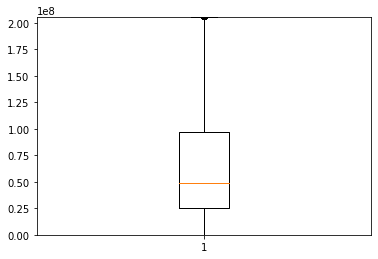

In [32]:
box=plt.boxplot(merged_df[merged_df['existing_loan_amt'].isnull()==False]['existing_loan_amt'], )
plt.ylim(0,2.05e+08)
plt.show()

In [30]:
box['whiskers'][1].get_ydata()

array([9.70e+07, 2.05e+08])

In [44]:
9.70e+07, 2.05e+08

(97000000.0, 205000000.0)

In [27]:
box['medians'][0].get_ydata()

array([49000000., 49000000.])

In [ ]:
old_id = user_id_list[0]
cnt=0
for uid in user_id_list:
    if uid != old_id:
        